Modify the water level from WRA after dicussing with 東霖 20211008. The water level in the raw data is already the calculated absolute elevation, using the sea level as the reference. The workflow is adopted from build_database_02.ipynb. Align "井頂高程" from "地下水觀測網抽水試驗成果彙整-V2.xlsx" to the data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use(['seaborn-colorblind', 'seaborn-talk'])
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta'] # to plot Chinese words properly

import datetime
date = datetime.datetime.now().strftime('%Y%m%d')

# Clean data

In [2]:
zaf_df = pd.read_csv('data/database_ZAF_wl_20211007.csv', dtype=object)
zaf_df.describe()

,井名,井號,水位(m),日期時間
count,38697849,38697849,38696441,38697849
unique,604,226,170728,250187
top,漢寶(3),7100211,-999998.0,2020-03-03 10:10
freq,173739,306676,955368,196


There are several things need to be checked:
1. The length of unique 井名 and 井號 is different.
1. There are negatives in the 水位(m).

## Compile data
1. Change well name: I'll just use the well id to find relevent well name in the excel file (環保署水利署地下水井.xlsx).
1. Align GPS to the data: use 環保署水利署地下水井.xlsx.
1. Align elevation to the data: use 地下水觀測網抽水試驗成果彙整-V2.xlsx.

In [3]:
excel_df = pd.read_excel('data/環保署水利署地下水井.xlsx')
excel_df.head()

,SiteId,SiteName,SiteEngName,County,Township,UgwDistName,TWD97Lon,TWD97Lat,TWD97TM2X,TWD97TM2Y,SiteAddress,StatusOfUse,數據紀錄始,數據紀錄終,資料數,data
0,4035,二林營運所,Erling Operation Center,彰化縣,二林鎮,濁水溪沖積扇,NaN,NaN,NaN,NaN,彰化縣二林鎮儒林路二段100號,廢站,1993/04,1999/05,18.0,環保署
1,4413,二崙國小,ErLun Elementary School,雲林縣,二崙鄉,濁水溪沖積扇,120.415102,23.771842,190386.40,2629878.33,雲林縣二崙鄉崙東村中興路36號,啟用,1999/08,2020/10,81.0,環保署
2,4133,二崙國小,ErLun Elementary School,雲林縣,二崙鄉,濁水溪沖積扇,NaN,NaN,NaN,NaN,雲林縣二崙鄉崙東村中興路36號,廢站,NaN,NaN,NaN,環保署
3,4403,口湖國小青蚶分校,"Kaohu Elementary School, Chingan Subdivision",雲林縣,口湖鄉,濁水溪沖積扇,120.161008,23.597331,164374.03,2610680.84,雲林縣口湖鄉青蚶村93號,啟用,1999/12,2020/10,84.0,環保署
4,4139,口湖國小青蚶分校,"Kaohu Elementary School, Chingan Subdivision",雲林縣,口湖鄉,濁水溪沖積扇,NaN,NaN,NaN,NaN,雲林縣口湖鄉青蚶村93號,廢站,NaN,NaN,NaN,環保署


In [12]:
excel2_df = pd.read_excel('data/地下水觀測網抽水試驗成果彙整-V2.xlsx', sheet_name='濁水溪沖積扇')
excel2_df.head()

,觀測站名,井號,TWD97(X),TWD97(Y),井頂高程\n(m),井深\n(m),導水係數\nT(m2/min),透水係數\nK(m/min),Q/s\n(cmh/m),Unnamed: 9,Unnamed: 10,濾水管頂\n(m),濾水管底\n(m),Sensor位置(m),出水量*\n(cmh),含水層\n屬性,岩性,Unnamed: 17
0,國聖(1),7010111,206194.06,2665352.132,21.31,24,0.2121,0.0077,7.680492,0.002133,0.003535,8,30,-12.00,-,U.C,NaN,NaN
1,國聖(2),7010121,206194.06,2665352.132,21.42,131.21,0.008,0.0007,0.551411,0.000153,0.000133,120,126,-20.02,0.55,U.C,NaN,NaN
2,國聖(3),7010131,206194.06,2665352.132,21.79,200,0.0053,0.0004,0.12701,0.000035,0.000088,185,197,-10.00,0.13,C,NaN,NaN
3,東芳(1),7010211,200779.08,2662059.143,11.38,132,0.6504,0.0163,22.609,0.006280,0.010840,101,125,-16.99,22.61,U.C.2,NaN,NaN
4,東芳(2),7010221,200779.08,2662059.143,11.37,181,0.5084,0.0424,17.937,0.004982,0.008473,162,174,-17.00,17.94,U.C.3,NaN,NaN


In [13]:
for well_id in zaf_df['井號'].unique():
    ex2_mask = excel2_df['井號'].astype(str) == str(well_id)
    if len(excel2_df.loc[ex2_mask, '井頂高程\n(m)'].values) == 0:
        print(well_id, len(zaf_df[zaf_df['井號'] == well_id]))

10080111 135162
10080131 135164
10080121 135164


These three sites should belong to 嘉南平原, so I'll just ignore them.

In [15]:
# try multiprocess
import dask.dataframe as dd
from dask import delayed
from dask.distributed import Client
client = Client(memory_limit='25GB')

In [16]:
def process(well_id, df, excel, excel2):
    X = df[df['井號'] == well_id].copy()
    ex1_mask = excel.SiteId.astype(str) == str(well_id)
    ex2_mask = excel2['井號'].astype(str) == str(well_id)
    X['井名'] = np.repeat(excel.loc[ex1_mask, 'SiteName'].values, len(X))
    X['Lon'] = np.repeat(excel.loc[ex1_mask, 'TWD97Lon'].values, len(X))
    X['Lat'] = np.repeat(excel.loc[ex1_mask, 'TWD97Lat'].values, len(X))
    # the well elevation and ignore those sites shouldn't belong to ZAF
    try:
        X['SiteEl'] = np.repeat(excel2.loc[ex2_mask, '井頂高程\n(m)'].values, len(X))
    except ValueError:
        print(well_id)
    return X
def concat(compile_list):
    return pd.concat(compile_list, axis=0, join='outer')

df_future = client.scatter(zaf_df)
#df_future = dd.read_csv('data/database_ZAF_wl_20211007.csv', dtype=object)
compile_list = []
for well_id in zaf_df['井號'].unique():
    df = delayed(process)(well_id, df_future, excel_df, excel2_df)
    compile_list.append(df)
    
total = delayed(concat)(compile_list)

In [17]:
total.visualize('results/modify_wl_{}.svg'.format(date))

In [18]:
# computation costs only 394s
zaf_mo = total.compute()

In [21]:
zaf_mo['日期時間'] = pd.to_datetime(zaf_mo['日期時間'])

In [22]:
zaf_mo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38697849 entries, 0 to 38388795
Data columns (total 7 columns):
 #   Column  Dtype         
---  ------  -----         
 0   井名      object        
 1   井號      object        
 2   水位(m)   object        
 3   日期時間    datetime64[ns]
 4   Lon     float64       
 5   Lat     float64       
 6   SiteEl  float64       
dtypes: datetime64[ns](1), float64(3), object(3)
memory usage: 2.3+ GB


## clean 水位 data
1. We already know all non-numeric values are '缺測' and the extreme negative are all -999998 (instrument defect), so I just need to change them into NA for later treating as missing values. 
1. Also if the 水位 is higher than the well elevation, it must be something wrong.

### Deal with non-numeric and -999998 values

In [23]:
zaf_mo['水位(m)'] = pd.to_numeric(zaf_mo['水位(m)'], errors='coerce')

In [28]:
zaf_mo2 = pd.concat([zaf_mo.iloc[:, [0, 1, 3, 4, 5, 6]], zaf_mo.loc[zaf_mo['水位(m)'] > -500, '水位(m)']], axis=1, join='outer')
zaf_mo2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38697849 entries, 0 to 38697848
Data columns (total 7 columns):
 #   Column  Dtype         
---  ------  -----         
 0   井名      object        
 1   井號      object        
 2   日期時間    datetime64[ns]
 3   Lon     float64       
 4   Lat     float64       
 5   SiteEl  float64       
 6   水位(m)   float64       
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 2.3+ GB


count    3.731924e+07
mean     1.196949e+01
std      3.848098e+01
min     -6.508000e+01
25%     -9.068000e+00
50%     -6.100000e-02
75%      1.931000e+01
max      1.988700e+02
Name: 水位(m), dtype: float64


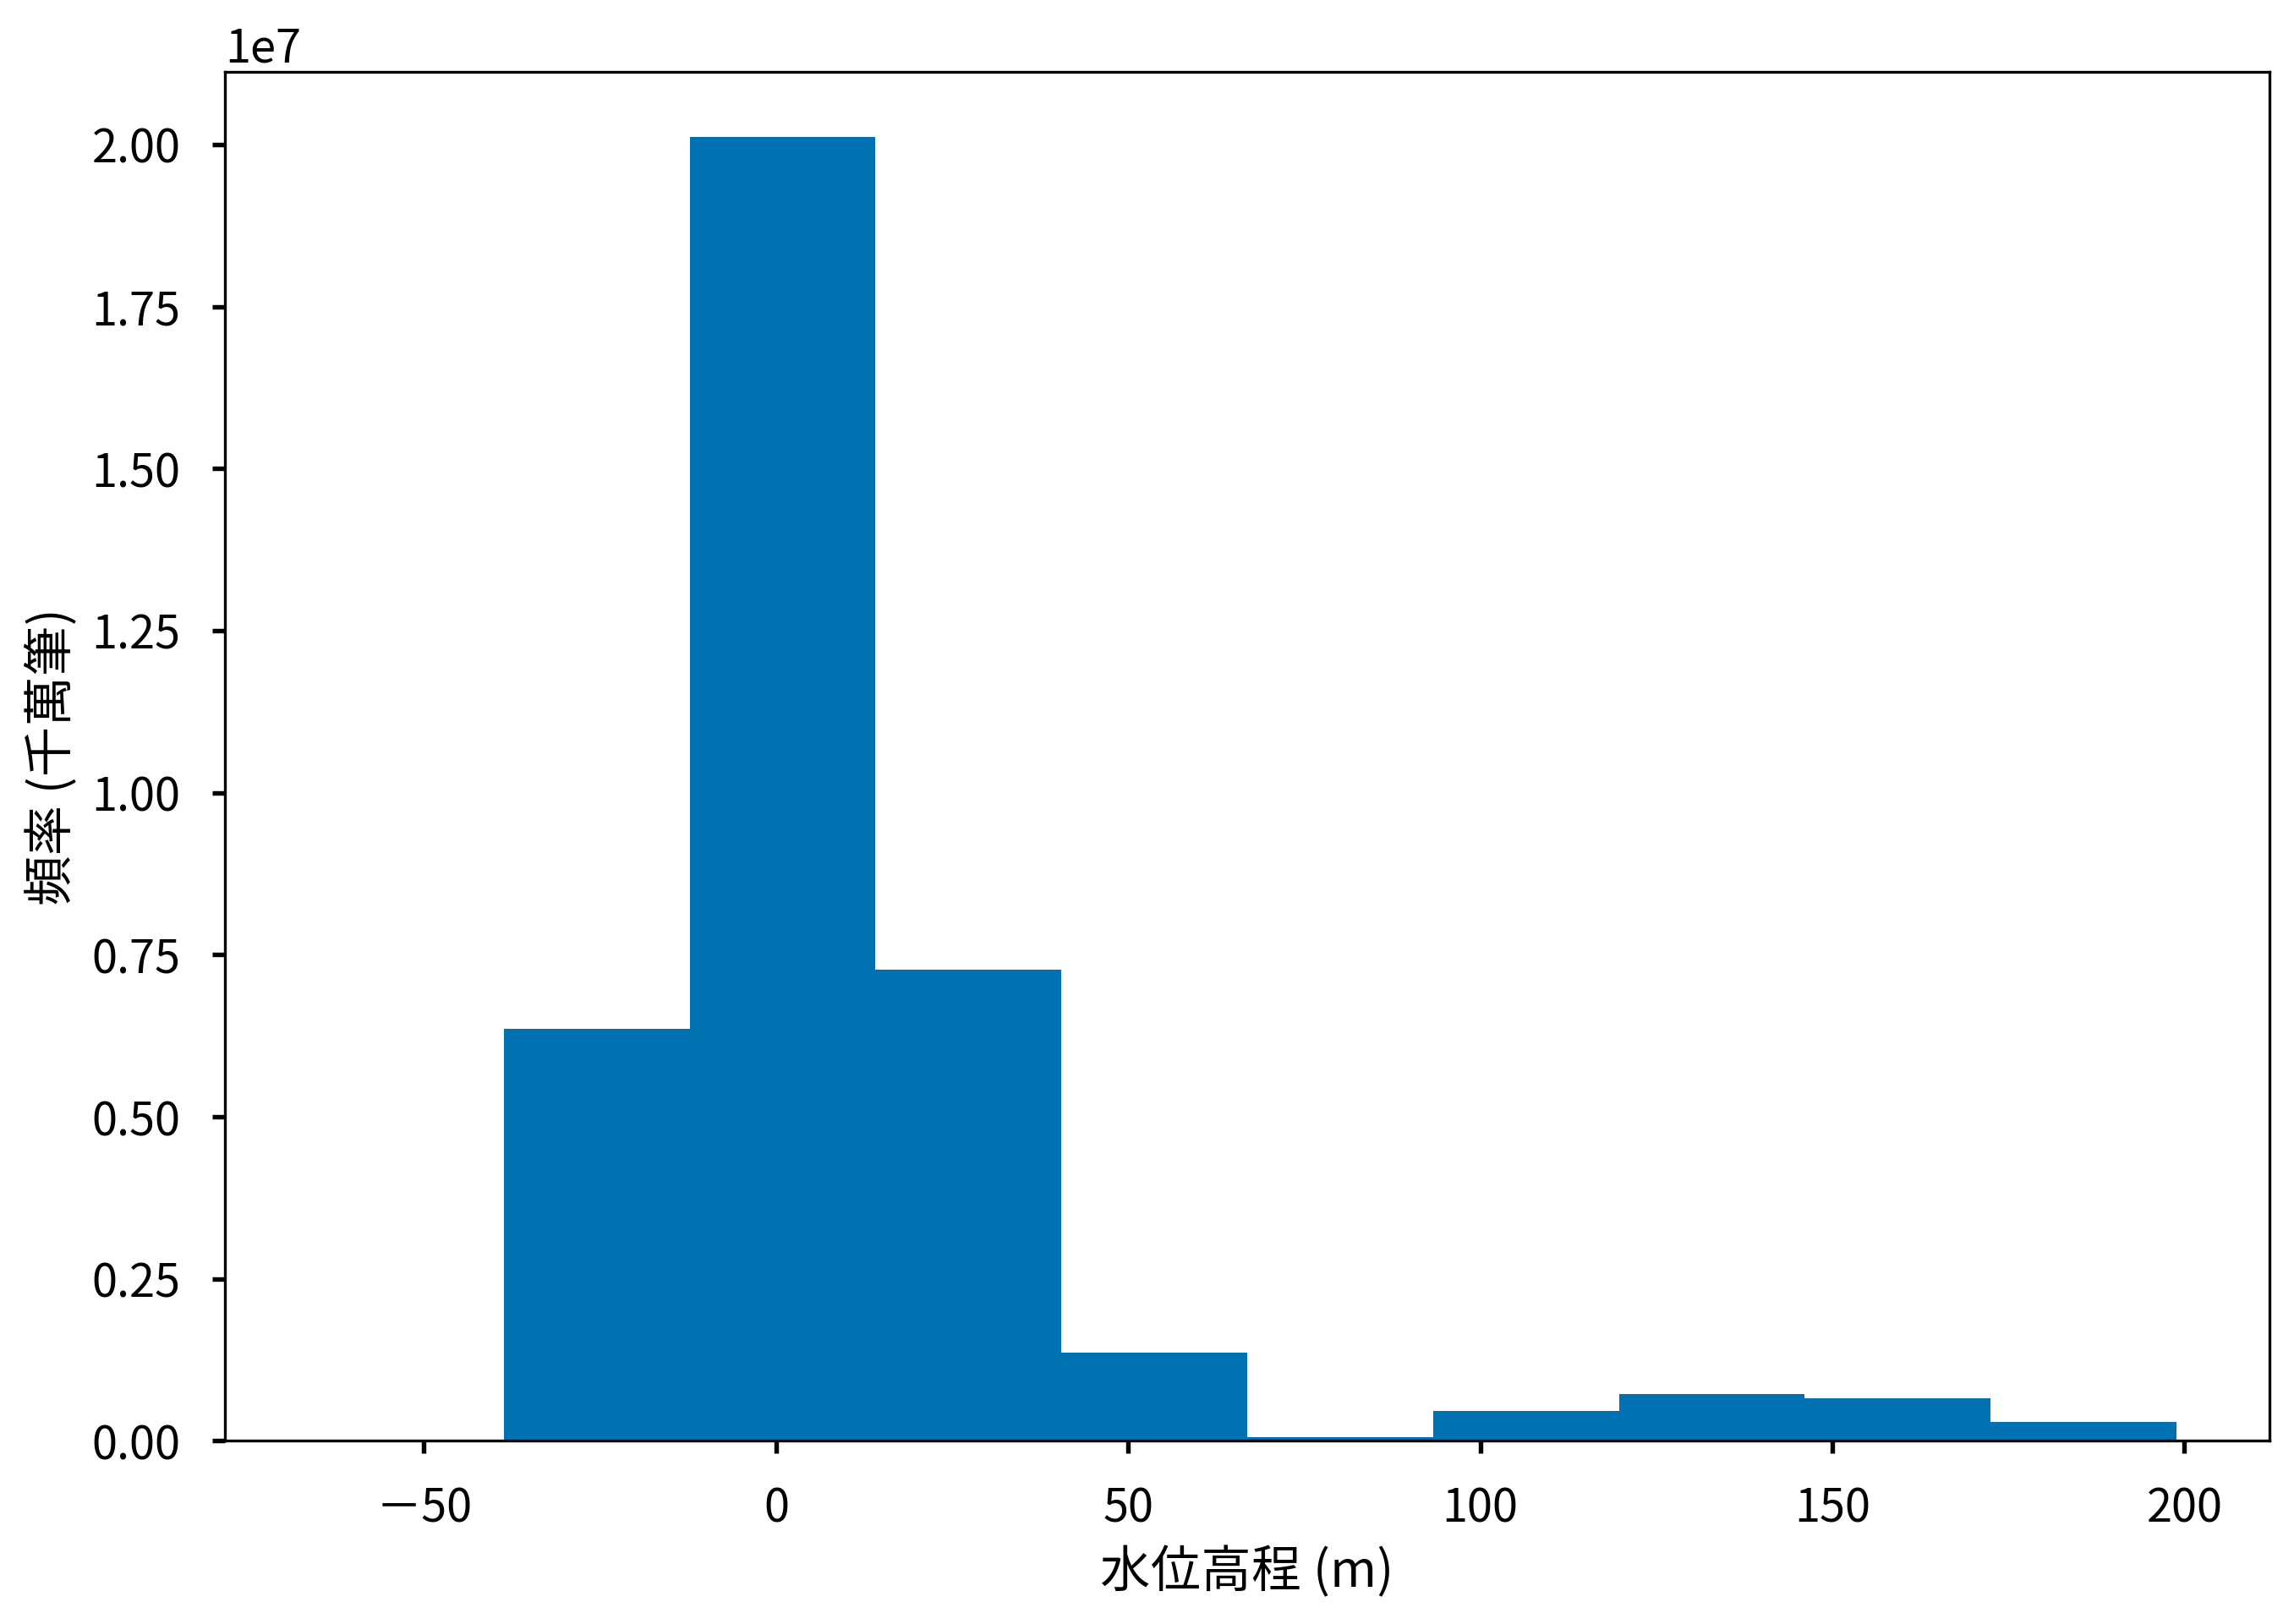

In [30]:
print(zaf_mo2['水位(m)'].describe())
plt.hist(zaf_mo2['水位(m)'])
plt.xlabel('水位高程 (m)')
plt.ylabel('頻率 (千萬筆)')
plt.savefig('results/wl_wra_data_hist_{}.png'.format(date))

### Find unreasonable high 水位
The aboslute elevation of water level (水位(m)) shouldn't be higher than that of well surface (SiteEl). Considering the possibility of artesian well and measurement bias, I take those points the water level is 1 meter higher than the surface (or more) as instrument defects. 

In [33]:
zaf_mo2[zaf_mo2['水位(m)'] > (zaf_mo2.SiteEl+1)]

,井名,井號,日期時間,Lon,Lat,SiteEl,水位(m)
55131,二水,7180111,2017-07-16 00:00:00,120.617922,23.811695,82.027,86.730
55132,二水,7180111,2017-07-17 00:00:00,120.617922,23.811695,82.027,86.730
55133,二水,7180111,2017-07-18 00:00:00,120.617922,23.811695,82.027,86.730
55134,二水,7180111,2017-07-19 00:00:00,120.617922,23.811695,82.027,86.730
55149,二水,7180111,2017-08-01 00:00:00,120.617922,23.811695,82.027,86.730
...,...,...,...,...,...,...,...
38121441,國聖(3),7010131,2021-09-21 23:10:00,120.569126,24.092658,21.790,26.785
38121442,國聖(3),7010131,2021-09-21 23:20:00,120.569126,24.092658,21.790,26.785
38121443,國聖(3),7010131,2021-09-21 23:30:00,120.569126,24.092658,21.790,26.785
38121444,國聖(3),7010131,2021-09-21 23:40:00,120.569126,24.092658,21.790,26.784


In [36]:
zaf_mo3 = pd.concat([zaf_mo2.iloc[:, :-1], zaf_mo2.loc[zaf_mo2['水位(m)'] < (zaf_mo2.SiteEl+1), '水位(m)']], axis=1, join='outer')
zaf_mo3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38697849 entries, 0 to 38697848
Data columns (total 7 columns):
 #   Column  Dtype         
---  ------  -----         
 0   井名      object        
 1   井號      object        
 2   日期時間    datetime64[ns]
 3   Lon     float64       
 4   Lat     float64       
 5   SiteEl  float64       
 6   水位(m)   float64       
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 2.3+ GB


We need to exclude the three sites (六腳123) that we decide to ignore in the begining.

In [47]:
zaf_mo3 = zaf_mo3[~zaf_mo3['井名'].isin(['六腳(1)', '六腳(2)', '六腳(3)'])]

In [48]:
print('There are {} points initially wihout measurement.'.format(zaf_df['水位(m)'].isna().sum()))
print('There are {} points recorded as 缺測.'.format((zaf_df['水位(m)']=='缺測').sum()))
print('There are {} points recorded as -999998.'.format((zaf_mo['水位(m)'] == -999998).sum()))
print('There are {} points having unreasonable high elevation.'.format((zaf_mo2['水位(m)'] > (zaf_mo2.SiteEl+1)).sum()))
print('We have {} points with valid values ({:.1f}% of the raw data).'.format(zaf_mo3['水位(m)'].count(), zaf_mo3['水位(m)'].count()/len(zaf_mo3)*100))

There are 1408 points initially wihout measurement.
There are 421836 points recorded as 缺測.
There are 955368 points recorded as -999998.
There are 127448 points having unreasonable high elevation.
We have 36813687 points with valid values (96.1% of the raw data).


## Calculate the defect rate of each well

In [50]:
# try multiprocess
#from dask import delayed
from dask.distributed import Client
client = Client(memory_limit='25GB')

In [51]:
def count(well_name, df):
    X = df[df['井名'] == well_name].copy()
    defect = X['水位(m)'].isna().sum()
    return [well_name, defect, round(defect/len(X)*100, 1)]

df_future = client.scatter(zaf_mo3)
compile_list = []
for well_name in zaf_mo3['井名'].unique():
    compile_list.append(delayed(count)(well_name, df_future))

In [43]:
delayed(compile_list).visualize('results/count_defect_rate_{}.svg'.format(date))

In [52]:
# computation costs only 287s
import dask
total = dask.compute(*compile_list)

In [53]:
rate_df = pd.DataFrame(total, columns=['井名', '負/缺值數', '不良率'])
rate_df

,井名,負/缺值數,不良率
0,顏厝,1,0.0
1,溪湖(1),18805,10.4
2,溪湖(2),12,0.0
3,溪湖(3),31218,17.0
4,田中(1),609,0.3
...,...,...,...
218,東芳(2),153,0.1
219,洛津(1),2,0.0
220,洛津(3),9550,6.9
221,洛津(2),1234,0.9


20211008


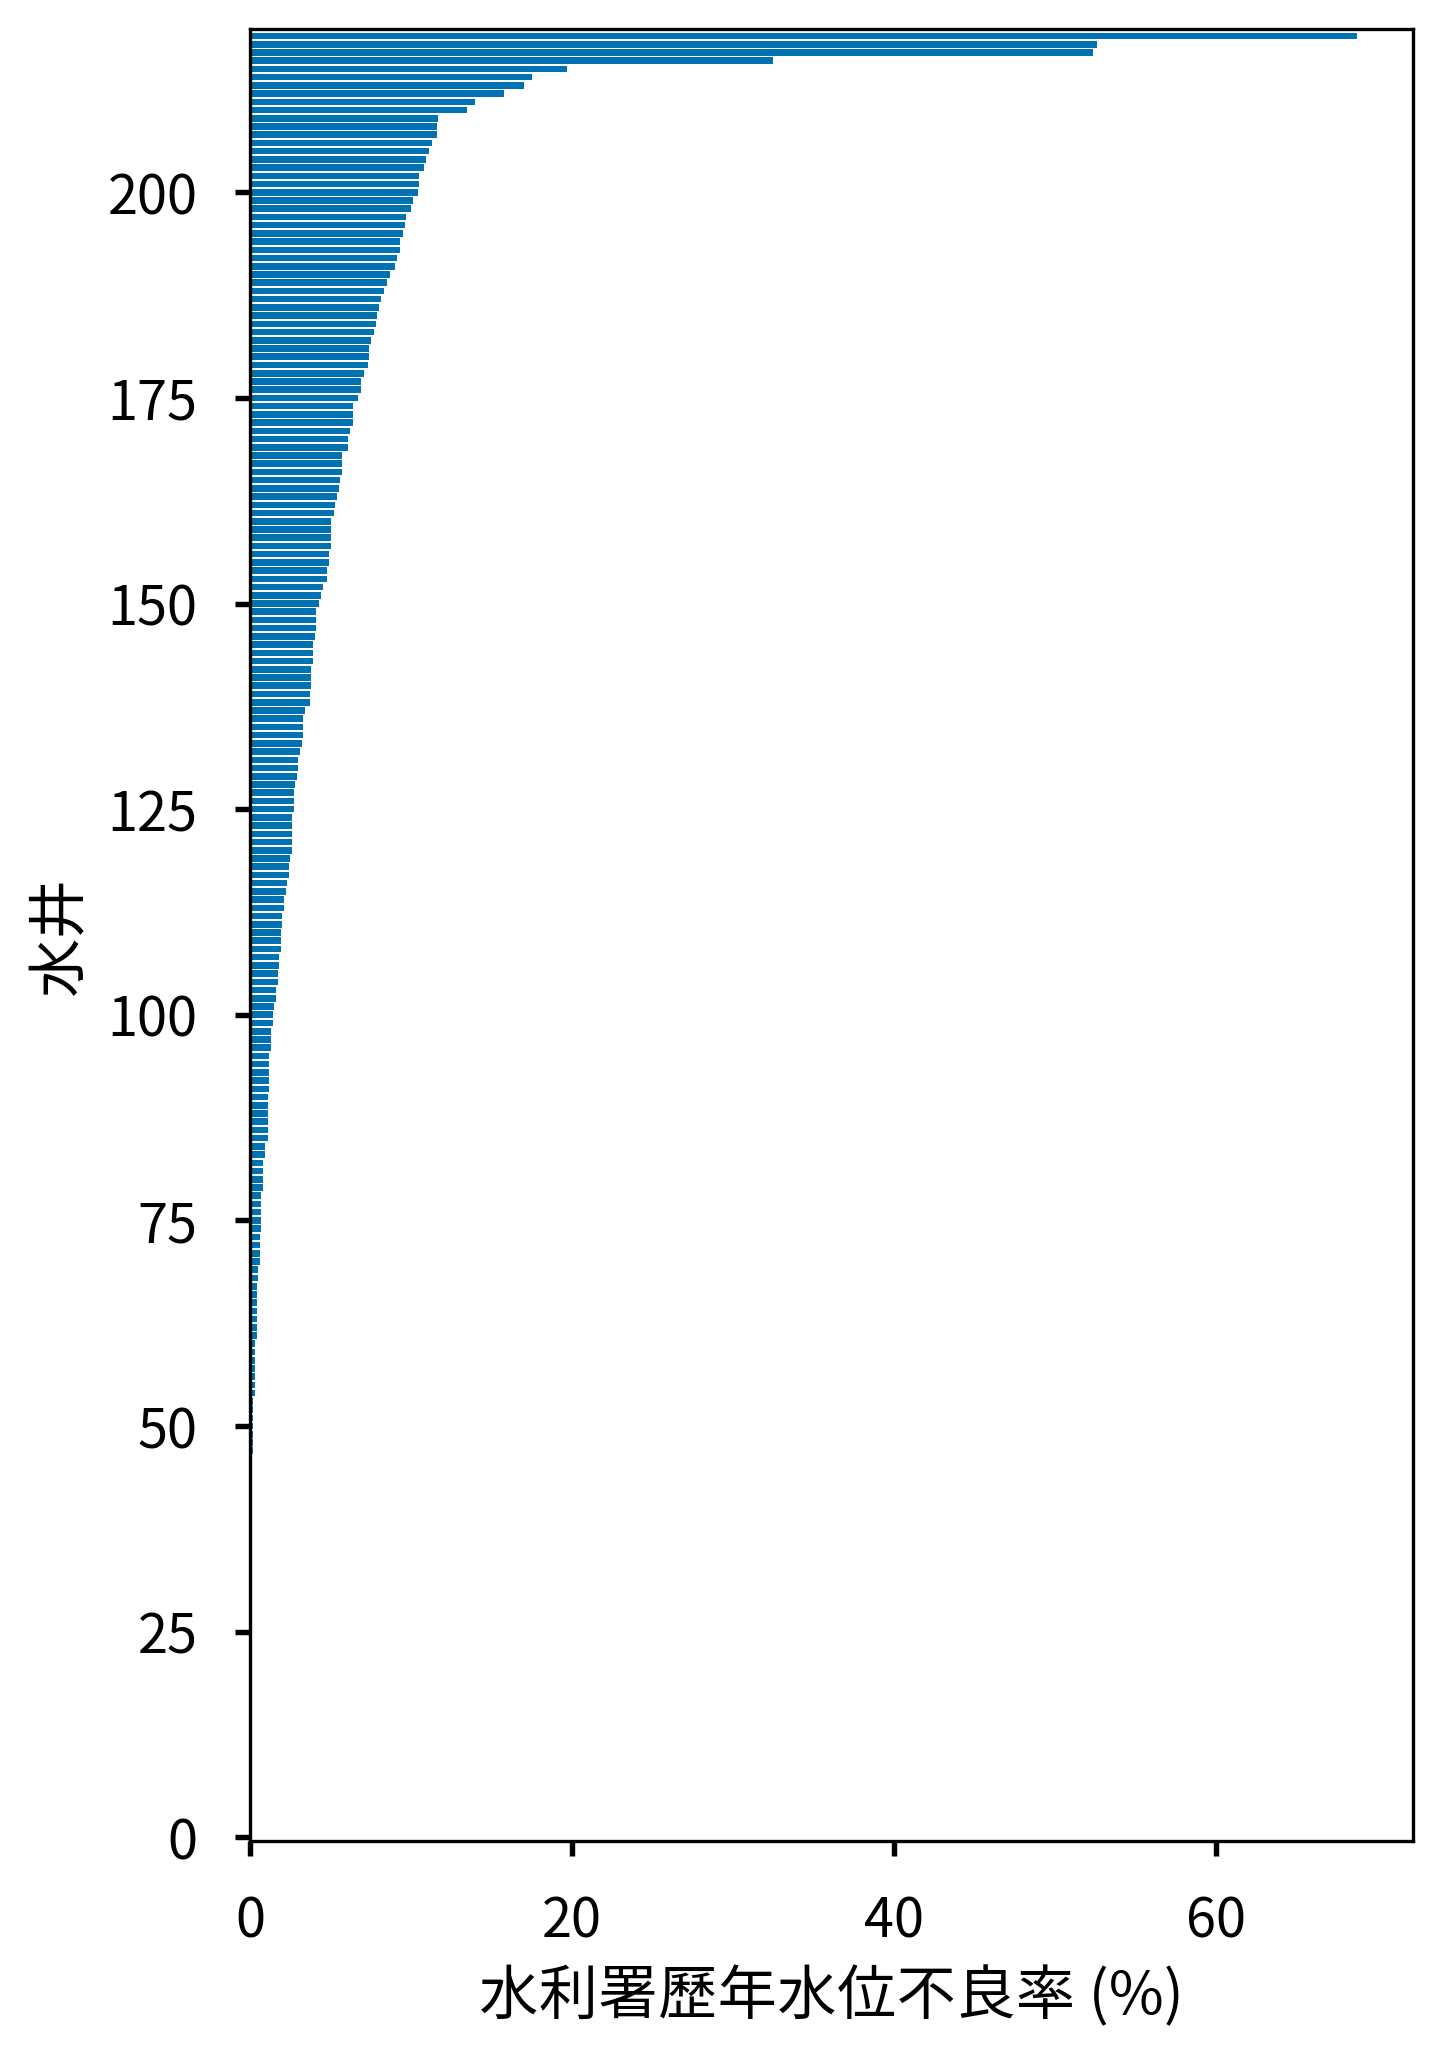

In [58]:
idx = np.argsort(rate_df['不良率'])
display_wells = 220
plt.figure(figsize=(5, 8))
plt.barh(range(display_wells), rate_df.iloc[idx[-display_wells::], 2])
plt.xlabel('水利署歷年水位不良率 (%)')
plt.ylabel('水井')
plt.ylim(-.5, display_wells-.2)
plt.savefig('results/wl_wra_defect_rate_all_{}.png'.format(date))
print(date)

20211008


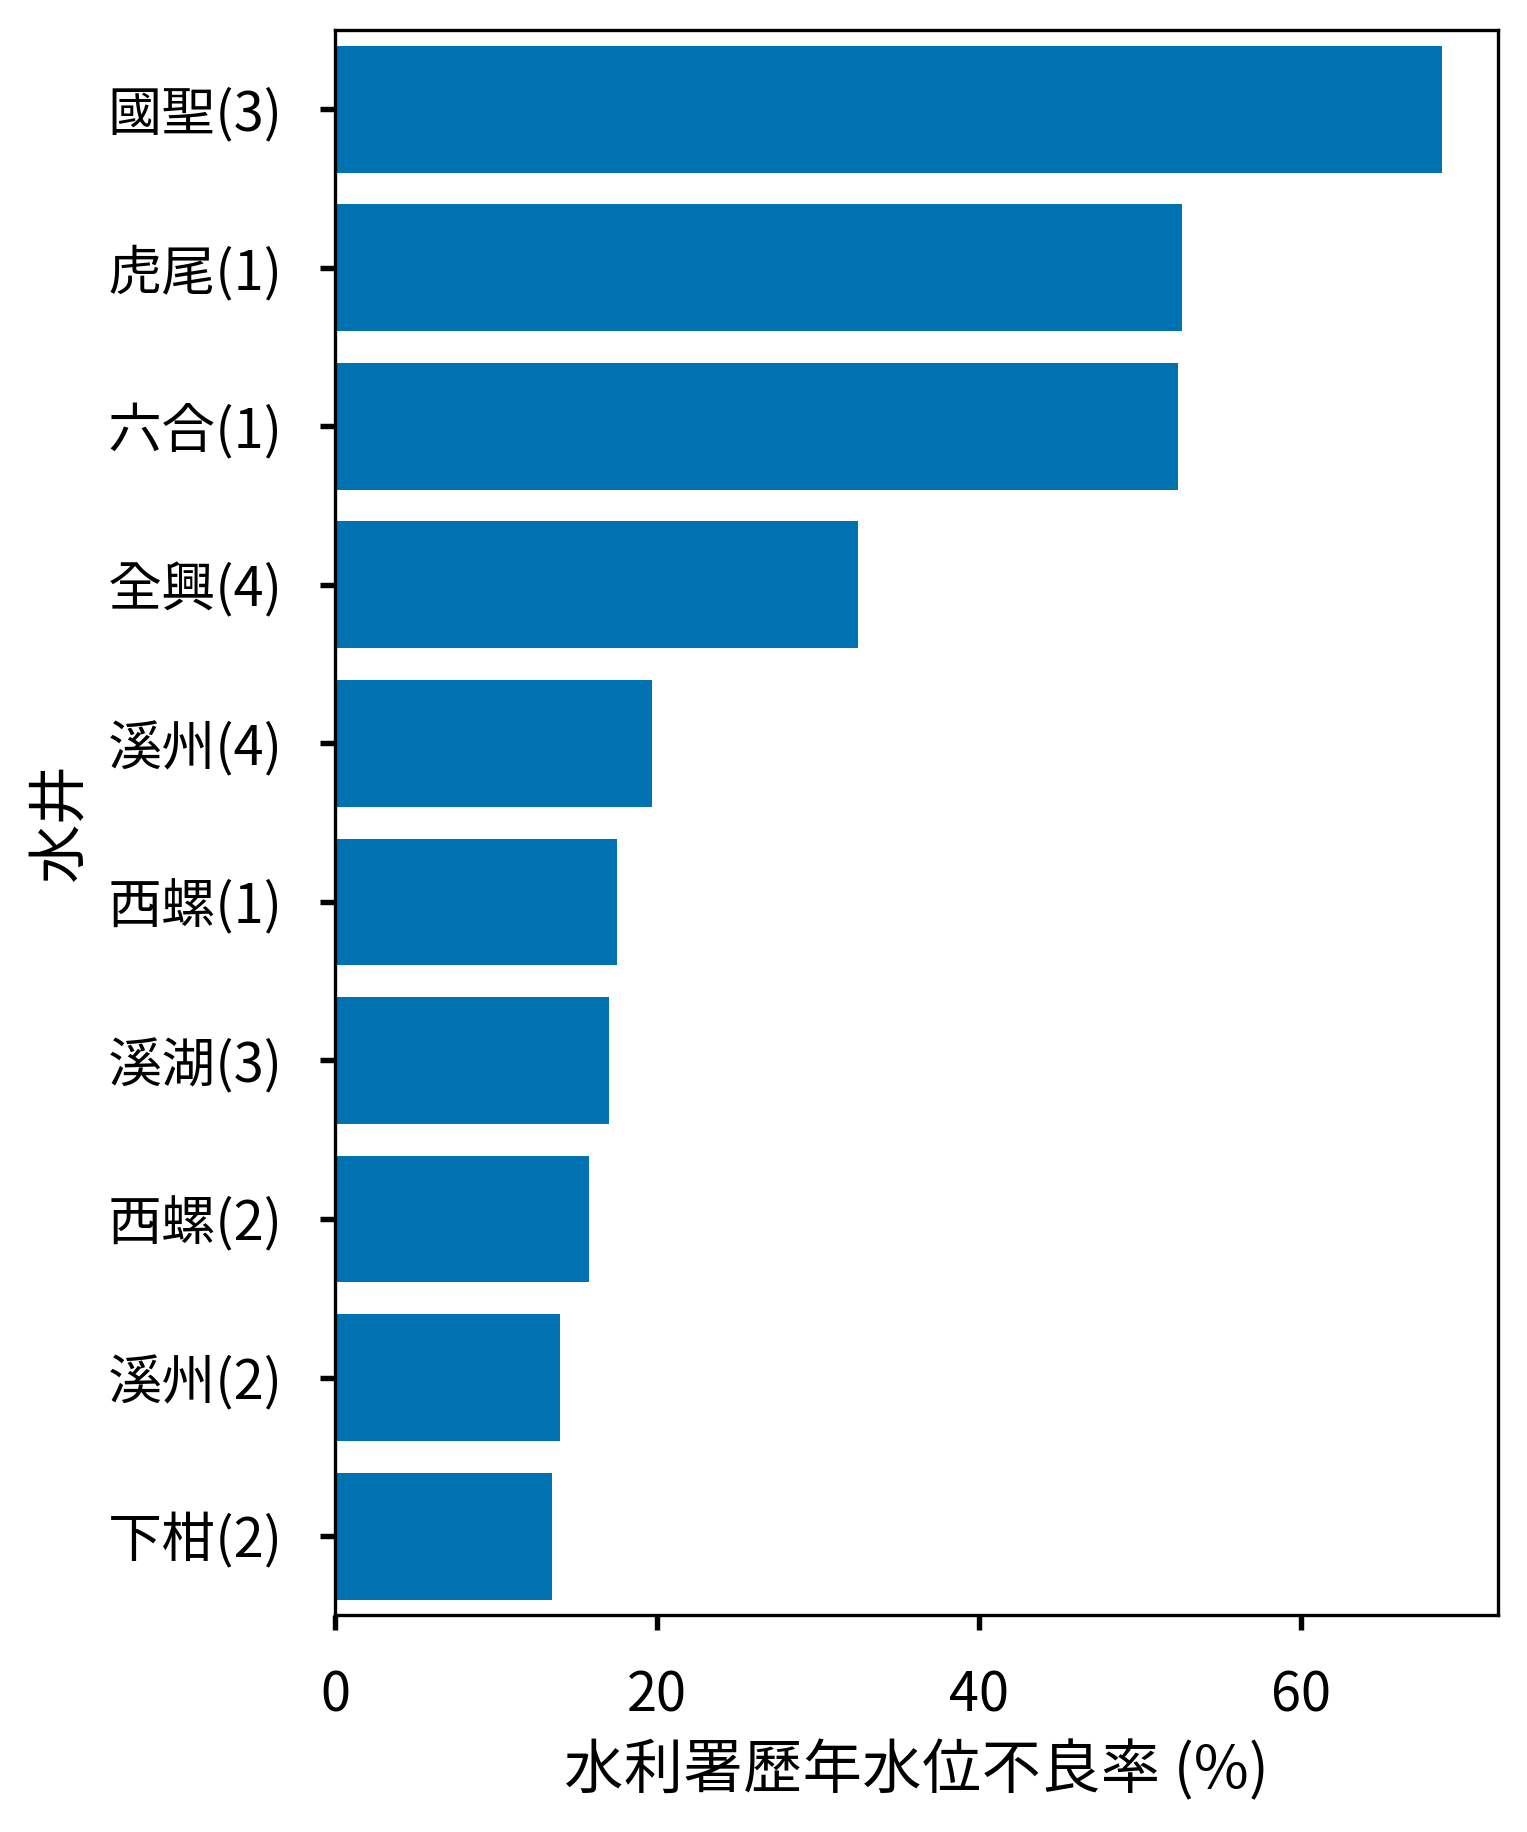

In [60]:
idx = np.argsort(rate_df['不良率'])
display_wells = 10
plt.figure(figsize=(5, 7))
plt.barh(rate_df.iloc[idx[-display_wells::], 0], rate_df.iloc[idx[-display_wells::], 2])
plt.xlabel('水利署歷年水位不良率 (%)')
plt.ylabel('水井')
plt.ylim(-.5, display_wells-.5)
#plt.savefig('results/wl_wra_defect_rate_{}_{}.png'.format(display_wells, date))
print(date)

# Output cleaned results
The output file's encoding is UTF-8 (default).

In [61]:
zaf_mo3.to_csv('data/database_ZAF_wl_clean_gps_{}.csv'.format(date), index=False)
print(date)

20211008


In [81]:
zaf_mo3.iloc[:, [0, 1, 2, 5, 6]].to_csv('data/database_ZAF_wl_clean_{}.csv'.format(date), index=False)
zaf_mo3.to_hdf('data/database_ZAF_clean_gps_{}.hd5'.format(date), key='wl', mode='w', encoding='utf-8')

C:\Users\An-Sheng\Miniconda3\envs\ncdr\lib\site-packages\pandas\core\generic.py:2703: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_values] [items->Index(['井名', '井號', '日期時間'], dtype='object')]

  pytables.to_hdf(


In [62]:
rate_df.to_csv('results/wl_wra_well_condition_{}.csv'.format(date), index=False)

In [63]:
client.close()

So far, I don't think intrapolation is necessary because we will use daily water level, or even monthly, which dilutes the influence of missing data.

# Play Geopandas

In [1]:
import pandas as pd
zaf_mo3 = pd.read_hdf('data/database_ZAF_clean_gps_20211008.hd5', key='wl')

In [2]:
zaf_mo3.head()

,井名,井號,日期時間,Lon,Lat,SiteEl,水位(m)
0,顏厝,070215T1,2007-01-24,120.434505,24.074449,5.13,0.48
1,顏厝,070215T1,2007-01-26,120.434505,24.074449,5.13,0.34
2,顏厝,070215T1,2007-01-27,120.434505,24.074449,5.13,0.71
3,顏厝,070215T1,2007-01-28,120.434505,24.074449,5.13,0.67
4,顏厝,070215T1,2007-01-29,120.434505,24.074449,5.13,0.16


In [3]:
# avoid error when later exporting shape files
zaf_mo3['日期時間'] = zaf_mo3['日期時間'].astype(str)

In [4]:
# exporting shape
zaf_mo3.columns = ['SiteName', 'SiteId', 'Timedate', 'Lon', 'Lat', 'SiteEl_m', 'WaterEl_m']

In [6]:
import geopandas as gd
gdf = gd.GeoDataFrame(
    zaf_mo3, geometry=gd.points_from_xy(zaf_mo3.Lon, zaf_mo3.Lat))
gdf.head()

,SiteName,SiteId,Timedate,Lon,Lat,SiteEl_m,WaterEl_m,geometry
0,顏厝,070215T1,2007-01-24,120.434505,24.074449,5.13,0.48,POINT (120.43451 24.07445)
1,顏厝,070215T1,2007-01-26,120.434505,24.074449,5.13,0.34,POINT (120.43451 24.07445)
2,顏厝,070215T1,2007-01-27,120.434505,24.074449,5.13,0.71,POINT (120.43451 24.07445)
3,顏厝,070215T1,2007-01-28,120.434505,24.074449,5.13,0.67,POINT (120.43451 24.07445)
4,顏厝,070215T1,2007-01-29,120.434505,24.074449,5.13,0.16,POINT (120.43451 24.07445)


In [7]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 38292359 entries, 0 to 38292358
Data columns (total 8 columns):
 #   Column     Dtype   
---  ------     -----   
 0   SiteName   object  
 1   SiteId     object  
 2   Timedate   object  
 3   Lon        float64 
 4   Lat        float64 
 5   SiteEl_m   float64 
 6   WaterEl_m  float64 
 7   geometry   geometry
dtypes: float64(4), geometry(1), object(3)
memory usage: 2.6+ GB


In [8]:
gdf = gdf.set_crs('EPSG:4326')
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

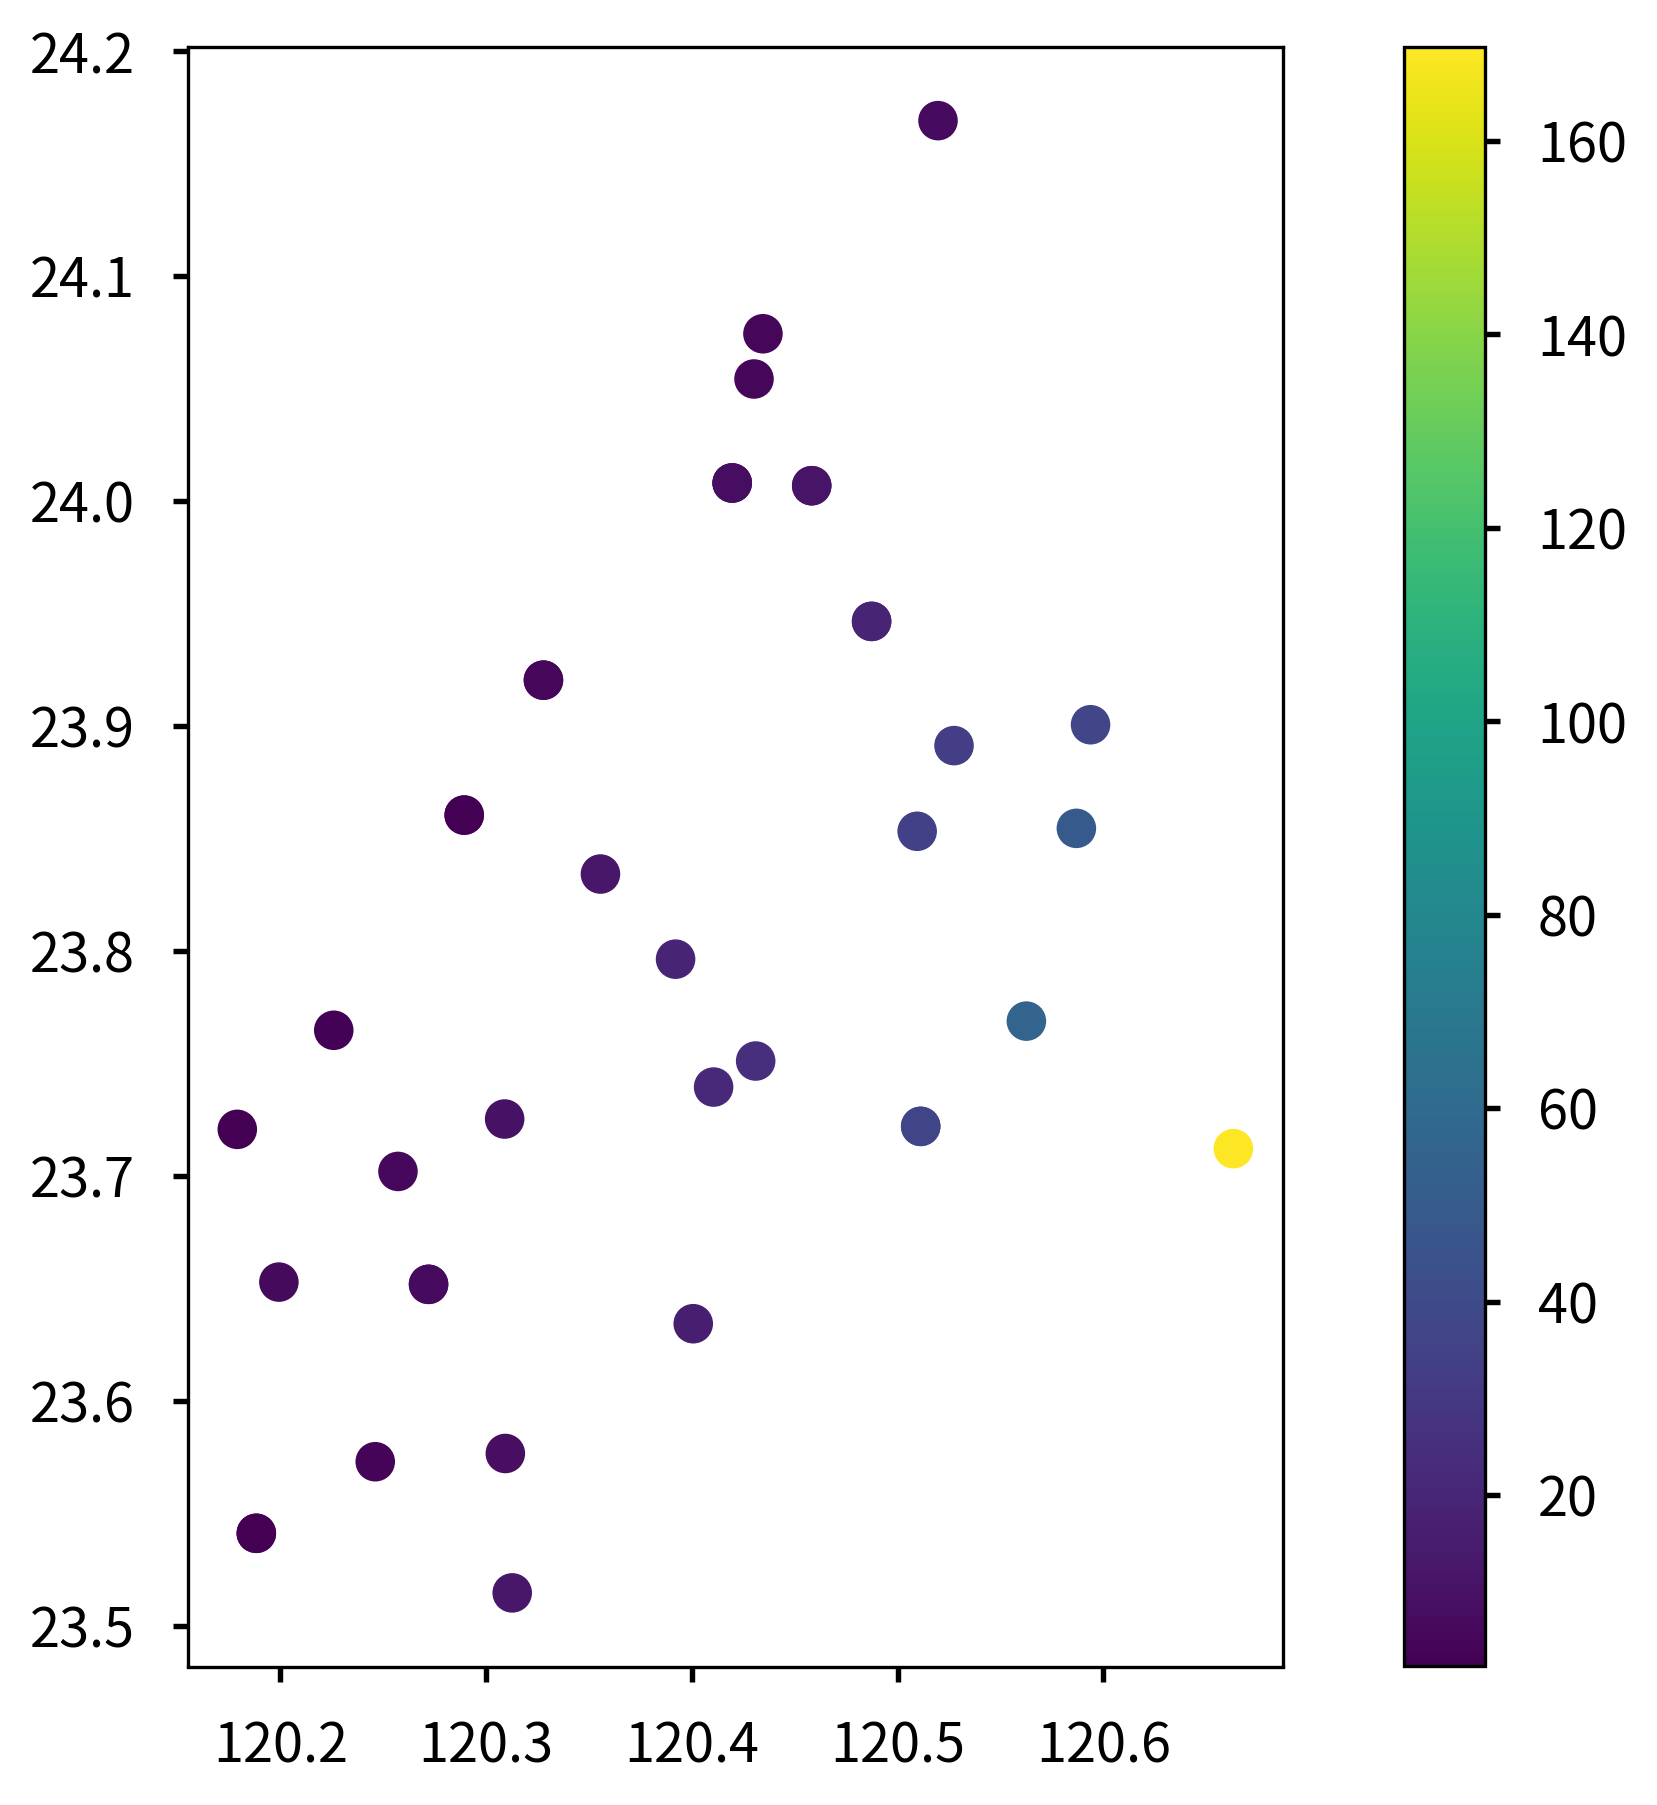

In [88]:
gdf.iloc[::1000000, :].plot('SiteEl_m', legend=True)

In [ ]:
# if want to transform to TWD97
gdf_97 = gdf.to_crs('EPSG:900913')

## Export shape files

In [10]:
# it costs...
gdf.to_file('data/ZAF_wl_wra_{}.shp'.format(date))